In [1]:
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from datetime import datetime
import sqlite3
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [2]:
# Retrieve data
ticker = 'AAPL'
end_date = datetime.now().strftime('%Y-%m-%d')
data = yf.download(ticker, start='2020-01-01', end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Create connection to sqlite
conn = sqlite3.connect(':memory:')

# Store data in table
data.to_sql('stock_prices', conn, if_exists='replace', index=True)


1156

In [5]:
# Retrieve data from sqlite
query = "SELECT* FROM stock_prices"
df = pd.read_sql(query, conn)
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1151,2024-07-31,221.440002,223.820007,220.630005,222.080002,222.080002,50036300
1152,2024-08-01,224.369995,224.479996,217.020004,218.360001,218.360001,62501000
1153,2024-08-02,219.149994,225.600006,217.710007,219.860001,219.860001,105568600
1154,2024-08-05,199.089996,213.500000,196.000000,209.270004,209.270004,119548600
1155,2024-08-06,205.300003,209.990005,201.070007,207.229996,207.229996,69660500


In [7]:
df["Close"].pct_change().describe()

count    1155.000000
mean        0.001090
std         0.020538
min        -0.128647
25%        -0.008893
50%         0.000928
75%         0.012284
max         0.119808
Name: Close, dtype: float64

In [8]:
real_test  = df.iloc[-1,:]

In [9]:
df["Close"] = df["Close"].shift(-1)
df = df.dropna()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1150,2024-07-30,219.190002,220.330002,216.119995,222.080002,218.800003,41643800
1151,2024-07-31,221.440002,223.820007,220.630005,218.360001,222.080002,50036300
1152,2024-08-01,224.369995,224.479996,217.020004,219.860001,218.360001,62501000
1153,2024-08-02,219.149994,225.600006,217.710007,209.270004,219.860001,105568600
1154,2024-08-05,199.089996,213.500000,196.000000,207.229996,209.270004,119548600


In [10]:
# Normalize and standardize the 'close' prices
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

In [11]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1150,2024-07-30,219.190002,220.330002,216.119995,2.079279,218.800003,41643800
1151,2024-07-31,221.440002,223.820007,220.630005,1.975744,222.080002,50036300
1152,2024-08-01,224.369995,224.479996,217.020004,2.017492,218.360001,62501000
1153,2024-08-02,219.149994,225.600006,217.710007,1.722753,219.860001,105568600
1154,2024-08-05,199.089996,213.500000,196.000000,1.665976,209.270004,119548600


In [12]:
scaler.inverse_transform(df[["Close"]])

array([[ 74.35749817],
       [ 74.94999695],
       [ 74.59750366],
       ...,
       [219.86000061],
       [209.27000427],
       [207.22999573]])

In [13]:
# Train a linear regression model
X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

df.head()


R-squared: 0.9679067422228945


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,-2.032115,72.960457,135480400
1,2020-01-03,74.287498,75.144997,74.125000,-2.015625,72.251114,146322800
2,2020-01-06,73.447502,74.989998,73.187500,-2.025435,72.826836,118387200
3,2020-01-07,74.959999,75.224998,74.370003,-1.992037,72.484360,108872000
4,2020-01-08,74.290001,76.110001,74.290001,-1.947228,73.650345,132079200


In [14]:
dep = pd.DataFrame(model.coef_).T

In [15]:
dep.columns = X.columns
dep

,Open,High,Low,Volume
0,-0.022168,0.02194,0.027991,2.159282e-11


In [16]:
model.intercept_

-4.080444969554058

In [17]:
pred = pd.DataFrame(y_pred, index= y_test)

In [18]:
y_test_true = scaler.inverse_transform(pd.DataFrame(y_test))
y_pred = scaler.inverse_transform(pred)

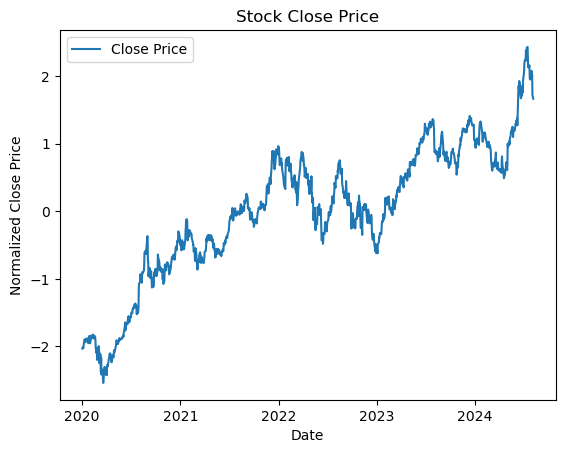

In [19]:
# Create a line chart of the 'Close' price
plt.plot(figsize=(10,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.title('Stock Close Price')
plt.legend()
plt.show()

In [20]:
import numpy as np

<Axes: >

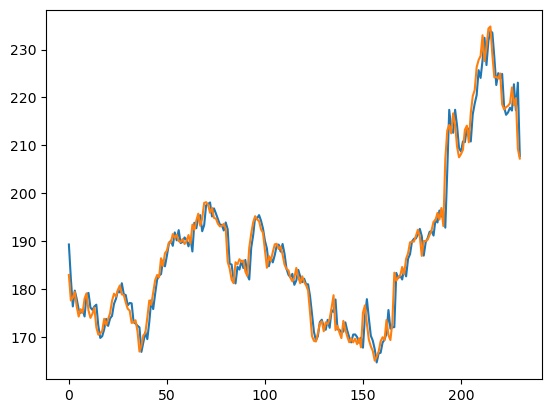

In [21]:
pd.Series(np.ravel(y_pred)).plot()
pd.Series(np.ravel(y_test_true)).plot()

<Axes: >

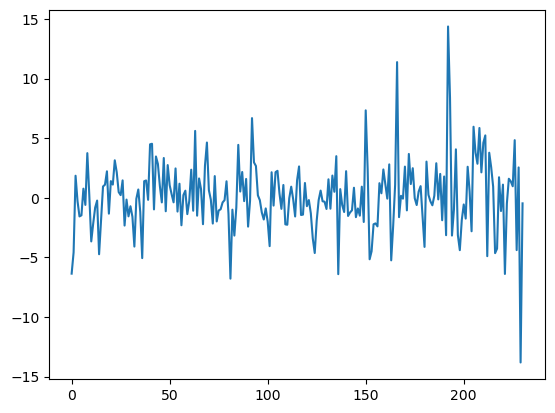

In [22]:
pd.Series(np.ravel(y_test_true) - np.ravel(y_pred)).plot()

In [22]:
pd.concat([pd.Series(np.ravel(y_test_true)),pd.Series(np.ravel(y_pred))], axis = "columns")

,0,1
0,182.910004,189.271829
1,177.559998,182.138798
2,178.179993,176.329609
3,179.360001,179.642768
4,176.300003,177.862423
...,...,...
226,222.080002,217.246637
227,218.360001,222.747899
228,219.860001,217.313551
229,209.270004,223.081453


In [23]:
np.mean(np.abs(np.ravel(y_test_true),np.ravel(y_pred)))

188.00593084690374

### Avoid look ahead bias
   1. Model already has been fed H, L, O --> so it knows that the close is going to be in between H and L
   2. Hence the margin of error is low.
   3. You cannot possibly know the highest daily high and lowest daily low as long as the trading day is still active.
4.    It always good to use lag for predicting time series.

### Tackling Overfitting in LSTM and Time Series Probelm:
 1. Dropout layers / Increasing the ratio.

 2. Regulization:
    -L1 --> Lasso
    -L2 --> Ridge
    -Elastic Net -- > L1 and L2
    
    
 3. Data Augmentation:
    -More Data
    -Feature engineering.
    
 4. Reducing Model Complexity: (If your model is too big.)
 
 5. Cross- Validation

 6. Batch Normalization

 7. Hyperparameter Tuning